In [8]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model

from hysteresis.base import BaseHysteresis
from hysteresis.hybrid import ExactHybridGP
from hysteresis.visualization import plot_hysterion_density

def ground_truth_function(m):
    return torch.sin(m)

def load():
    toy_model = torch.load('toy_magnet_decay.pt')

    train_h = toy_model.history_h.reshape(-1, 1)
    train_m = toy_model.history_m.reshape(-1, 1)

    train_y = ground_truth_function(train_m) + torch.randn(train_m.shape) * 0.0
    return train_h, train_m, train_y, toy_model

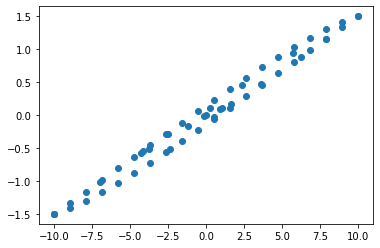

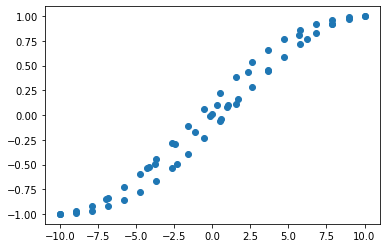

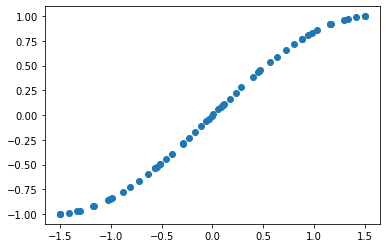

In [9]:
train_x, train_m, train_y, toy_model = load()
plt.figure()
plt.plot(train_x, train_m, 'o')

plt.figure()
plt.plot(train_x, train_y,'o')

plt.figure()
plt.plot(train_m, train_y,'o')

In [10]:
H = BaseHysteresis(
    train_x.flatten(),
    polynomial_degree=1,
    mesh_scale=0.1,
    trainable=True
)
model = ExactHybridGP(train_x, train_y.flatten().clone(), H)
mll = ExactMarginalLogLikelihood(model.gp.likelihood, model)

In [11]:
res = fit_gpytorch_model(mll)
for name, val in model.named_parameters():
    print(f'{name}:{val}')

hysteresis_models.0.raw_hysterion_density:Parameter containing:
tensor([ 2.6590e-09,  4.7171e-09, -3.9849e-08,  ...,  5.3765e-09,
         1.1260e-09,  2.7806e-09], requires_grad=True)
hysteresis_models.0.raw_offset:Parameter containing:
tensor([2.4110e-17], requires_grad=True)
hysteresis_models.0.raw_scale:Parameter containing:
tensor([-0.0002], requires_grad=True)
hysteresis_models.0.raw_slope:Parameter containing:
tensor([-0.0004], requires_grad=True)
hysteresis_models.0.transformer._poly_fit.weights:Parameter containing:
tensor([-1.3834e-06], requires_grad=True)
hysteresis_models.0.transformer._poly_fit.bias:Parameter containing:
tensor([2.4110e-20], requires_grad=True)
gp.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([1.0000e-04], dtype=torch.float64, requires_grad=True)
gp.mean_module.constant:Parameter containing:
tensor([2.5182e-06], dtype=torch.float64, requires_grad=True)
gp.covar_module.raw_outputscale:-0.00014232405279605265
gp.covar_module.base_kernel.raw_l

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

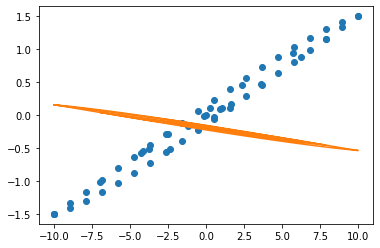

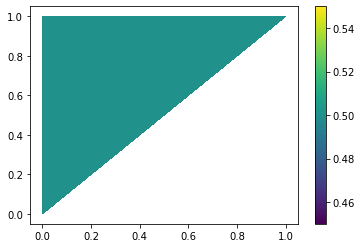

In [12]:
# prediction of hysteresis
model.hysteresis_models[0].regression()
plt.figure()
plt.plot(train_x, train_m, 'o')
plt.plot(
    train_x,
    model.hysteresis_models[0](train_x.flatten(), return_real=True).detach()
)

plot_hysterion_density(model.hysteresis_models[0])

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\models\exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


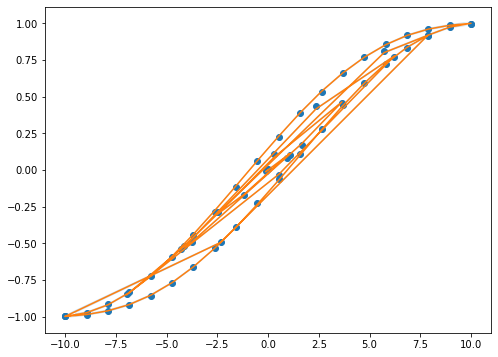

In [13]:
# compare fit to data
with torch.no_grad():
    post = model(train_x.double())
    mean_out = post.mean
    l, u = post.confidence_region()
plt.figure(figsize=(8,6))
plt.plot(train_x, train_y, 'o')
plt.plot(train_x, mean_out.detach())
plt.fill_between(train_x.flatten(), l.flatten(), u.flatten(), alpha=0.25)

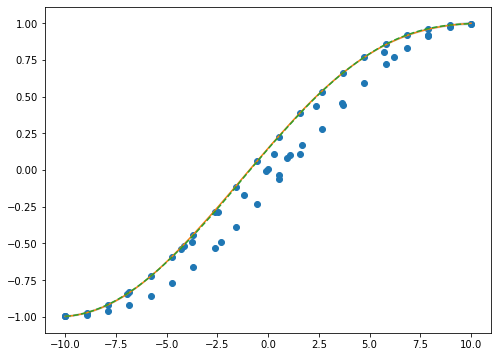

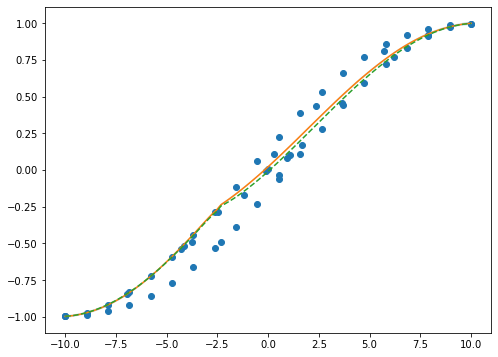

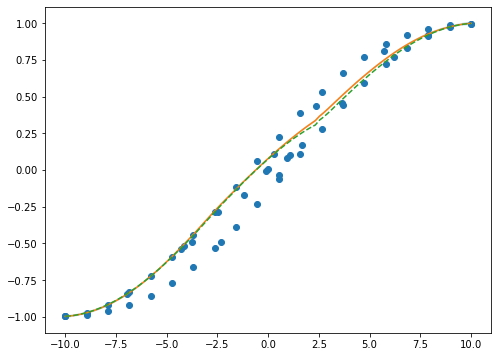

In [14]:
# predict with joint model
flds = torch.tensor([10.0, -2.5, 2.5])
for ele in flds:
    toy_model.apply_field(ele)
    toy_model.next()

    model.apply_fields(ele.reshape(1,1))
    model.next()

    test_x = torch.linspace(*H.valid_domain, 100)
    with torch.no_grad():
        post = model(test_x.double().reshape(-1, 1))
        mean = post.mean
        l, u = post.confidence_region()

    m_gt = toy_model(test_x.double().reshape(-1,1))
    y_gt = ground_truth_function(m_gt).squeeze().detach()

    plt.figure(figsize=(8,6))
    plt.plot(train_x, train_y, 'o')
    plt.plot(test_x, mean.detach().flatten())
    plt.fill_between(test_x.flatten(), l.flatten(), u.flatten(), alpha=0.25)
    plt.plot(test_x, y_gt,'--')


